In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import sys

sys.path.insert(1, str(Path().cwd().parent))
import common_config

In [2]:
common_config.figure_journal_basic()

In [3]:
import pertpy as pt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import pickle

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
adata = pt.dt.mcfarland_2020()
adata

AnnData object with n_obs × n_vars = 182875 × 32738
    obs: 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID'
    var: 'ensembl_id', 'ncounts', 'ncells'

We want to query the GDSC scores for the cell line-perturbation combinations in our dataset. We tested annotating either via SangerID, COSMICID, or cell line name. We found that most cell lines are identifeir when using the SangerID.

In [5]:
cl_metadata = pt.md.CellLine()

cl_metadata.annotate(
    adata,
    query_id="DepMap_ID",
    reference_id="ModelID",
    fetch=["SangerModelID"],
)

cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation='perturbation',
    gdsc_dataset=1,
)
adata.obs["ln_ic50_GDSC1"] = adata.obs["ln_ic50"].copy()

cl_metadata.annotate_from_gdsc(
    adata,
    query_id="SangerModelID",
    reference_id="sanger_model_id",
    query_perturbation='perturbation',
    gdsc_dataset=2,
)
adata.obs["ln_ic50_GDSC2"] = adata.obs["ln_ic50"].copy()

del adata.obs["ln_ic50"]
adata

💡 There are 172 identifiers in `adata.obs`.However, 32 identifiers can't be found in the drug response annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...
💡 There are 172 identifiers in `adata.obs`.However, 32 identifiers can't be found in the drug response annotation,leading to the presence of NA values for their respective metadata.
Please check again: *unmatched_identifiers[:verbosity]...


AnnData object with n_obs × n_vars = 182875 × 32738
    obs: 'SangerModelID', 'perturbation', 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'ln_ic50_GDSC1', 'ln_ic50_GDSC2'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [7]:
adata.obs[["perturbation", "ln_ic50_GDSC2"]].drop_duplicates()["perturbation"].value_counts()

perturbation
Trametinib     115
Navitoclax      68
Dabrafenib      67
Gemcitabine     65
Afatinib        65
Taselisib       64
JQ1             63
Bortezomib      16
sgLACZ           1
sgGPX4-2         1
sgGPX4-1         1
control          1
AZD5591          1
Prexasertib      1
Idasanutlin      1
Everolimus       1
BRD3379          1
sgOR2J2          1
Name: count, dtype: int64

In [8]:
adata.obs[["ln_ic50_GDSC1", "ln_ic50_GDSC2"]].corr()

,ln_ic50_GDSC1,ln_ic50_GDSC2
ln_ic50_GDSC1,1.000000,0.839123
ln_ic50_GDSC2,0.839123,1.000000


In [9]:
adata = adata[adata.obs["perturbation"].isin(["control", "Trametinib"])]
adata

View of AnnData object with n_obs × n_vars = 70443 × 32738
    obs: 'SangerModelID', 'perturbation', 'DepMap_ID', 'cancer', 'cell_det_rate', 'cell_line', 'cell_quality', 'channel', 'disease', 'dose_unit', 'dose_value', 'doublet_CL1', 'doublet_CL2', 'doublet_GMM_prob', 'doublet_dev_imp', 'doublet_z_margin', 'hash_assignment', 'hash_tag', 'num_SNPs', 'organism', 'percent.mito', 'perturbation_type', 'sex', 'singlet_ID', 'singlet_dev', 'singlet_dev_z', 'singlet_margin', 'singlet_z_margin', 'time', 'tissue_type', 'tot_reads', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'chembl-ID', 'ln_ic50_GDSC1', 'ln_ic50_GDSC2'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [21]:
def comp_edger(adata_temp, perturbation):
    adata_temp = adata_temp[adata_temp.obs["perturbation"].isin(["control", perturbation])]
    
    logfc_df = pd.DataFrame(columns=adata_temp.var_names)
    
    for cell_line in tqdm(adata_temp.obs["SangerModelID"].unique()):
        
        subset = adata_temp[adata_temp.obs["SangerModelID"] == cell_line]
        if subset.n_obs < 20: #Threshold from the McFarland paper
            continue
        
        edgr = pt.tl.EdgeR(subset, design="~perturbation")
        edgr.fit()
        
        res_df = edgr.test_contrasts(edgr.contrast("perturbation", "control", perturbation))
        res_df = res_df[["variable", "log_fc"]]
        res_df = res_df.set_index("variable")
        res_df = res_df.reindex(adata.var_names)
        
        logfc_df.loc[cell_line] = res_df["log_fc"]
    
    with open(f"data/logfc_df_{perturbation}.pkl", "wb") as f:
        pickle.dump(logfc_df, f)
    
    return logfc_df

100%|██████████| 139/139 [1:37:05<00:00, 41.91s/it] 


In [23]:
logfc_df = comp_edger(adata, "Trametinib")

,MIR1302-10,FAM138A,OR4F5,RP11-34P13.7,RP11-34P13.8,AL627309.1,RP11-34P13.14,RP11-34P13.9,AP006222.2,RP4-669L17.10,...,KIR3DL2-1,AL590523.1,CT476828.1,PNRC2-1,SRSF10-1,AC145205.1,BAGE5,CU459201.1,AC002321.2,AC002321.1
SIDM00139,0.0,0.0,0.0,0.013670,0.0,-0.035638,0.0,0.0,0.200579,-0.004455,...,0.0,0.0,0.0,0.071283,-0.107314,0.0,0.0,0.000000,0.0,0.0
SIDM00956,0.0,0.0,0.0,-0.005628,0.0,-0.032378,0.0,0.0,0.526867,-0.040614,...,0.0,0.0,0.0,-0.050723,-0.069216,0.0,0.0,-0.008534,0.0,0.0
SIDM00947,0.0,0.0,0.0,-0.025716,0.0,-0.041304,0.0,0.0,-0.074146,-0.038903,...,0.0,0.0,0.0,0.053517,0.088853,0.0,0.0,0.000000,0.0,0.0
SIDM00726,0.0,0.0,0.0,0.059869,0.0,0.024477,0.0,0.0,0.304163,0.000000,...,0.0,0.0,0.0,-0.061378,0.008453,0.0,0.0,0.000000,0.0,0.0
SIDM00235,0.0,0.0,0.0,0.058846,0.0,0.003077,0.0,0.0,0.301462,-0.014199,...,0.0,0.0,0.0,-0.022942,0.373510,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM01055,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,-0.684194,0.269435,...,0.0,0.0,0.0,0.140932,-0.045569,0.0,0.0,0.000000,0.0,0.0
SIDM00909,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.116314,0.000000,...,0.0,0.0,0.0,-0.154563,-0.469799,0.0,0.0,0.000000,0.0,0.0
SIDM00564,0.0,0.0,0.0,-0.230564,0.0,-0.427998,0.0,0.0,0.145299,0.000000,...,0.0,0.0,0.0,0.199462,0.518099,0.0,0.0,0.000000,0.0,0.0
SIDM00575,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.501901,0.000000,...,0.0,0.0,0.0,0.000000,0.189748,0.0,0.0,0.000000,0.0,0.0


In [60]:
import statsmodels.api as sm

lr_params = pd.DataFrame(columns=["gene", "slope", "intercept", "slope_pval", "intercept_pval"])

cell_lines = logfc_df.index
sens_cell_lines = adata.obs[["ln_ic50_GDSC2", "SangerModelID"]].drop_duplicates().dropna().set_index("SangerModelID")
cell_lines = [cell_line for cell_line in cell_lines if cell_line in sens_cell_lines.index]

X = sens_cell_lines.loc[cell_lines]["ln_ic50_GDSC2"].values
na_mask = np.isnan(X)
X = X[~na_mask]

for gene in tqdm(adata.var_names):
    y = logfc_df.loc[cell_lines][gene].values
    y = y[~na_mask]
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    
    lr_params.loc[gene] = [gene, results.params[1], results.params[0], results.pvalues[1], results.pvalues[0]]

100%|██████████| 32738/32738 [02:20<00:00, 233.70it/s]


<Axes: xlabel='intercept', ylabel='-log10(intercept_pval)'>

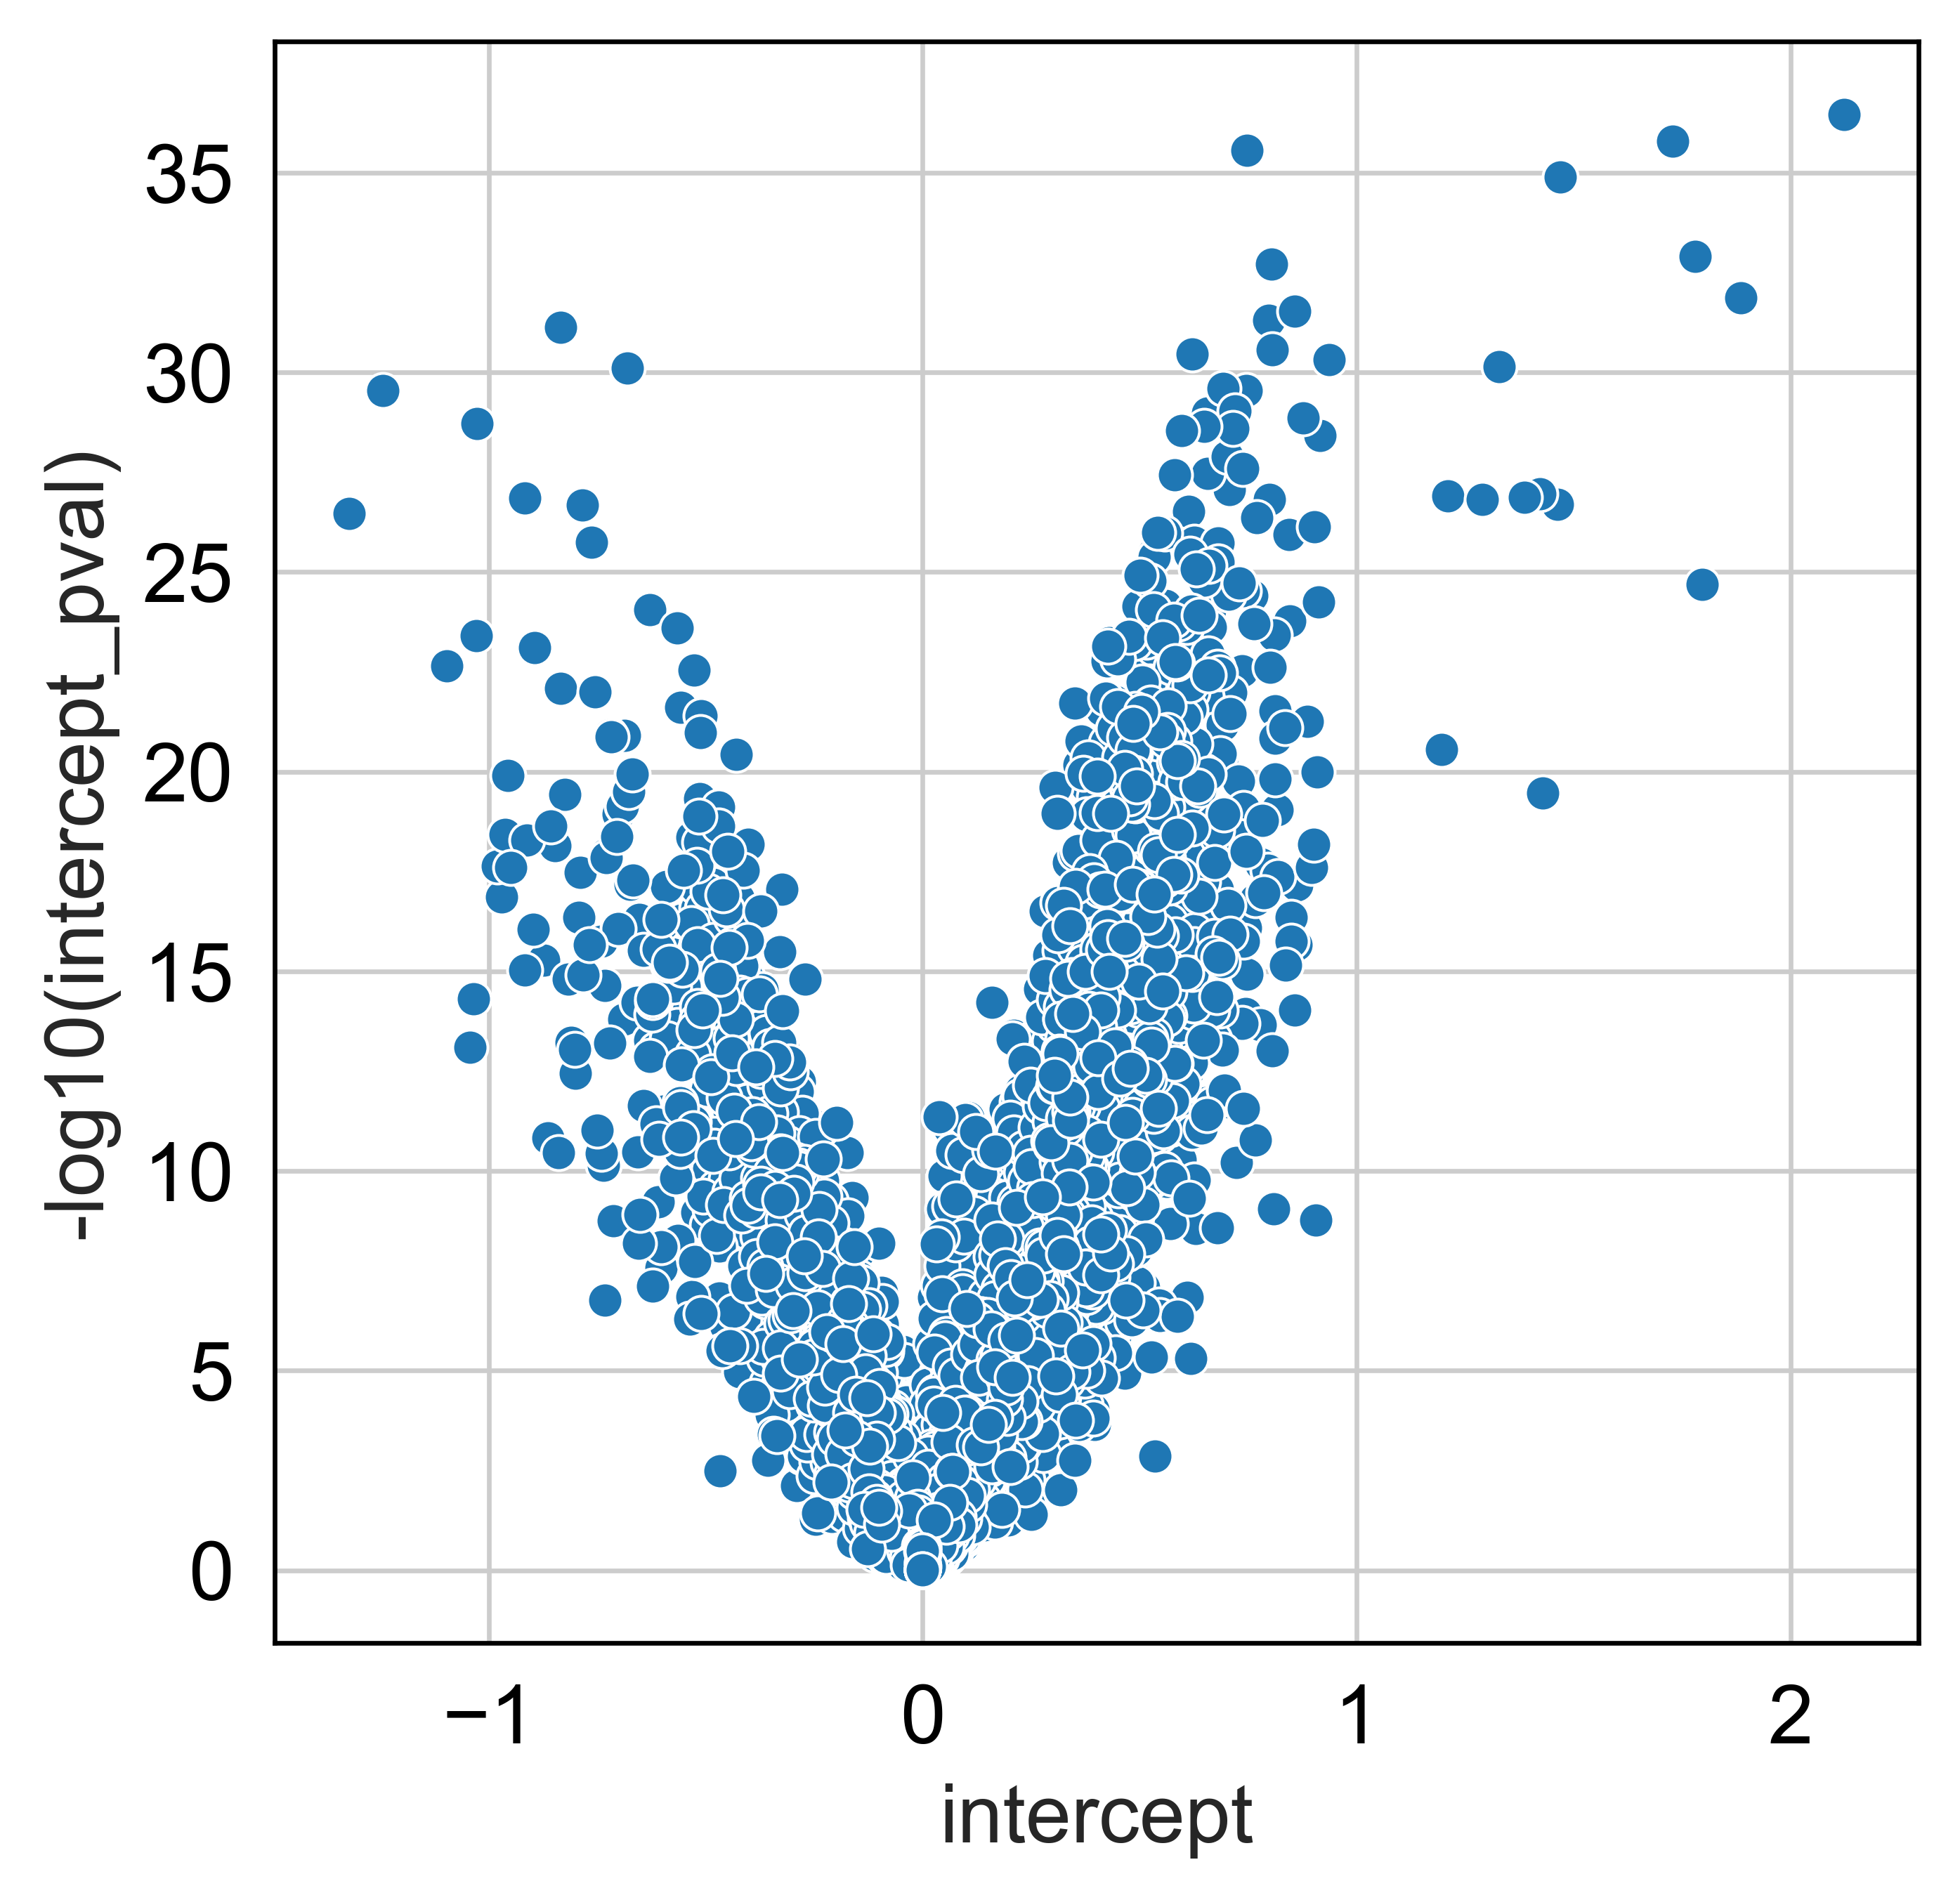

In [61]:
lr_params["-log10(slope_pval)"] = -np.log10(lr_params["slope_pval"])
lr_params["-log10(intercept_pval)"] = -np.log10(lr_params["intercept_pval"])

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    data=lr_params,
    x="intercept",
    y="-log10(intercept_pval)",
    ax=ax,
)

In [62]:
lr_params[(lr_params["intercept"] < -0.5) & (lr_params["-log10(intercept_pval)"] > 15)]

,gene,slope,intercept,slope_pval,intercept_pval,-log10(slope_pval),-log10(intercept_pval)
ISG15,ISG15,0.065330,-1.027182,0.022141,1.900434e-29,1.654798,28.721147
FBXO2,FBXO2,0.045493,-0.599331,0.096269,1.411312e-16,1.016516,15.850377
IFI6,IFI6,0.133860,-1.243223,0.000108,2.890558e-30,3.966425,29.539018
PDZK1IP1,PDZK1IP1,0.090812,-0.970405,0.032440,1.355187e-17,1.488924,16.868001
IFI44L,IFI44L,0.076706,-0.955704,0.036339,1.217447e-20,1.439628,19.914550
...,...,...,...,...,...,...,...
BLVRB,BLVRB,0.052746,-0.609765,0.062148,2.773521e-16,1.206571,15.556968
AC006262.5,AC006262.5,-0.045678,-0.583352,0.095913,5.923328e-16,1.018121,15.227434
APOL6,APOL6,0.010635,-0.602197,0.690446,4.944663e-17,0.160870,16.305863
APOL1,APOL1,-0.000709,-0.717655,0.978351,1.321204e-21,0.009506,20.879030


In [63]:
lr_params.loc["EGR1"]

gene                           EGR1
slope                      0.007988
intercept                  1.428757
slope_pval                 0.884791
intercept_pval                  0.0
-log10(slope_pval)          0.05316
-log10(intercept_pval)    19.466776
Name: EGR1, dtype: object

<Axes: xlabel='intercept', ylabel='-log10(intercept_pval)'>

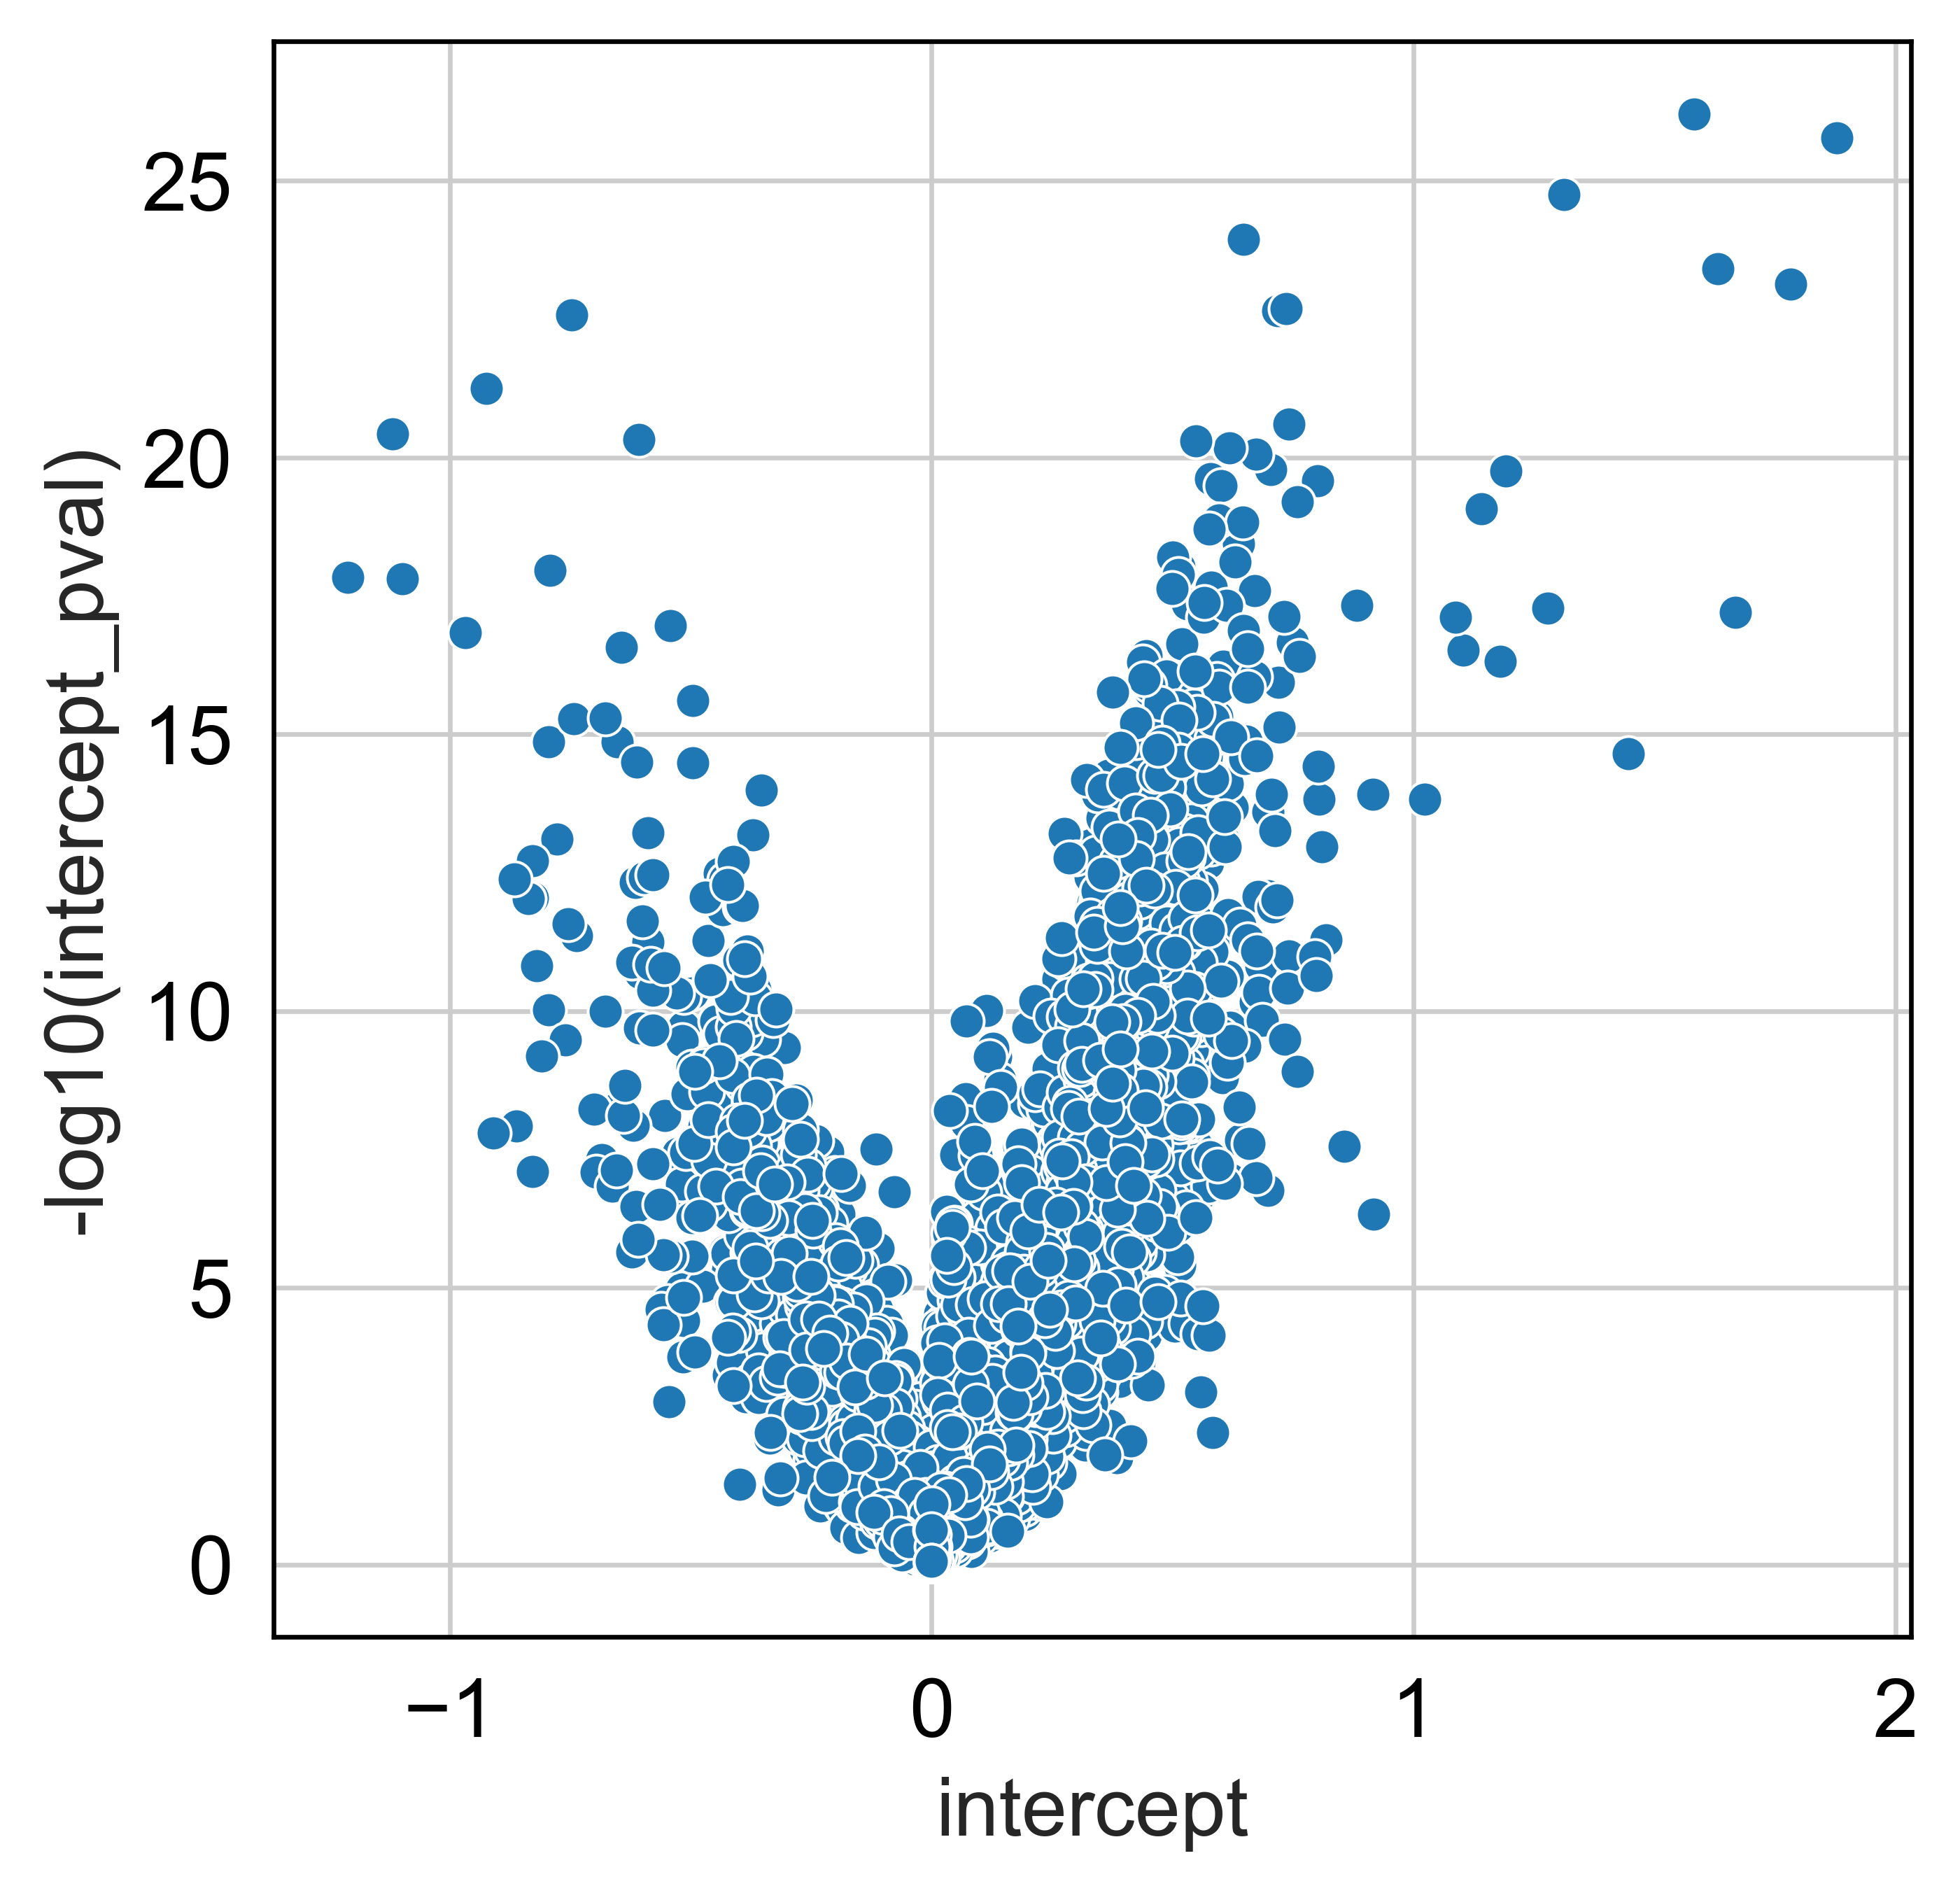

In [57]:
#Plot volcano plot
lr_params["-log10(slope_pval)"] = -np.log10(lr_params["slope_pval"])
lr_params["-log10(intercept_pval)"] = -np.log10(lr_params["intercept_pval"])

fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    data=lr_params,
    x="intercept",
    y="-log10(intercept_pval)",
    ax=ax,
)

In [58]:
lr_params[(lr_params["intercept"] < -0.5) & (lr_params["-log10(intercept_pval)"] > 15)]

,gene,slope,intercept,slope_pval,intercept_pval,-log10(slope_pval),-log10(intercept_pval)
ISG15,ISG15,0.091454,-0.923951,0.000262,5.644542e-22,3.582347,21.248371
IFI6,IFI6,0.109017,-1.118739,0.000491,3.764070e-21,3.308657,20.424342
RHOB,RHOB,0.023615,-1.098288,0.476837,1.530024e-18,0.321630,17.815302
STAT1,STAT1,0.069600,-0.747649,0.000287,2.610279e-23,3.542265,22.583313
PARP9,PARP9,0.079404,-0.644196,0.000223,2.684511e-17,3.652287,16.571135
DTX3L,DTX3L,0.050117,-0.608069,0.003003,4.689391e-21,2.522426,20.328884
PARP14,PARP14,0.083011,-0.792114,0.000743,1.096108e-18,3.128830,17.960147
OAS1,OAS1,0.086821,-0.742783,0.000924,5.295988e-16,3.034453,15.276053
OAS3,OAS3,0.030870,-0.542722,0.072816,1.078560e-17,1.137775,16.967156
IFI27,IFI27,0.074336,-1.211179,0.044398,1.456991e-18,1.352633,17.836543


In [59]:
lr_params.loc["EGR1"]

gene                           EGR1
slope                      0.012159
intercept                  1.445047
slope_pval                 0.811083
intercept_pval                  0.0
-log10(slope_pval)         0.090935
-log10(intercept_pval)    14.653182
Name: EGR1, dtype: object

# Old: LR with Sklearn

In [ ]:
lr_params = pd.DataFrame(columns=["gene", "slope", "intercept", "slope_pval", "intercept_pval"])

lr = LinearRegression()
cell_lines = logfc_df.index
X = adata.obs[["ln_ic50_GDSC1", "SangerModelID"]].drop_duplicates().set_index("SangerModelID").loc[cell_lines]["ln_ic50_GDSC1"].values
na_mask = np.isnan(X)
X = X[~na_mask]

for gene in adata.var_names:
    y = logfc_df[gene].values
    y = y[~na_mask]
    lr.fit(X.reshape(-1, 1), y)
    
    assert len(lr.coef_) == 1
    lr_params.loc[gene] = [gene, lr.coef_[0], lr.intercept_, 